# MNIST Classifier

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore")

## Loading Data

- autorii SimpleNet au folosit un split de 60000 train si 10000 eval

In [2]:
train = pd.read_csv("/home/iustin/SimpleNet_Pytorch/MNIST/data/MNIST_train.csv")
test = pd.read_csv("/home/iustin/SimpleNet_Pytorch/MNIST/data/MNIST_test.csv")

In [3]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [4]:
# Create features and targets
y_train = train['label']
X_train = train.drop(columns=['label'])

## Visualization

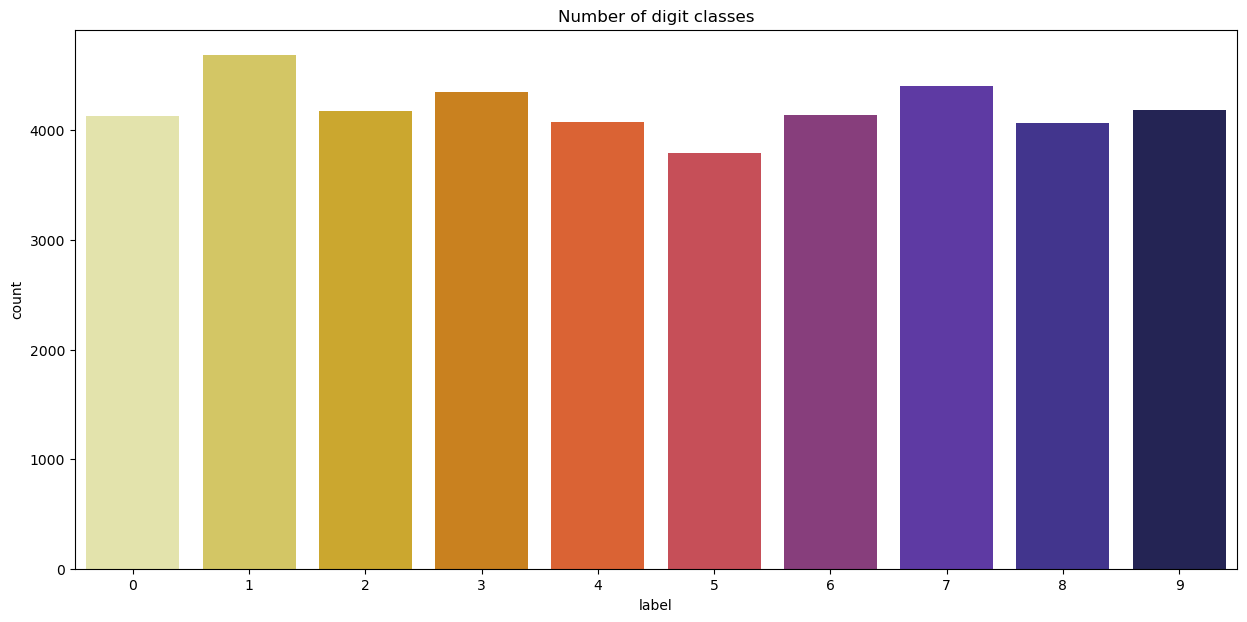

In [5]:
plt.figure(figsize=(15,7))
g = sns.countplot(x=y_train, palette="CMRmap_r")
plt.title("Number of digit classes")
plt.show();

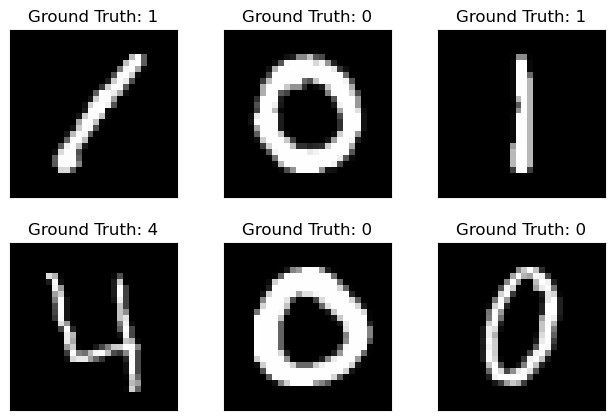

In [6]:
fig = plt.Figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train.values[i].reshape((28, 28)), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
plt.show();

## Dataset Class

In [7]:
class DigitDataset(Dataset):
    def __init__(self, X, y, augmentations=None):
        self.inputs = (X / 255.0).to_numpy().astype(np.float32).reshape(-1,1,28,28)
        self.targets = y.values
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        if self.augmentations is not None:
            return torch.FloatTensor(self.augmentations(img=image)['image']), torch.FloatTensor(label)
        else:
            return torch.tensor(self.inputs[idx, :]), torch.tensor(self.targets[idx])

## DataLoaders

In [8]:
BATCH_SIZE = 64
# Split our trainset in train and eval
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [9]:
# Create datasets without augmentation
train_set = DigitDataset(X_train, y_train, None)
test_set = DigitDataset(X_eval, y_eval, None)

In [10]:
len(test_set)

8400

> Note:
>
>We can set the batch size for our test loader to the length of the dataset. This is because during testing, the focus is on assessing the model's generalization to unseen data, and there's no >need to perform batch-wise operations.

In [11]:
# Create dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set))

## Building the Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

In [13]:
LEARNING_RATE = 0.08
MOMENTUM = 0.5
NUM_EPOCH = 10
EVAL_STEP = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = Net().to(device)
criterion = nn.CrossEntropyLoss() # Commonly used for multiclass predictions
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [14]:
from torchinfo import summary

summary(model, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Net (Net)                                [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 12, 12]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 26, 26]      320                  True
│    └─ReLU (1)                          [1, 32, 26, 26]      [1, 32, 26, 26]      --                   --
│    └─Conv2d (2)                        [1, 32, 26, 26]      [1, 64, 24, 24]      18,496               True
│    └─ReLU (3)                          [1, 64, 24, 24]      [1, 64, 24, 24]      --                   --
│    └─MaxPool2d (4)                     [1, 64, 24, 24]      [1, 64, 12, 12]      --                   --
│    └─Dropout2d (5)                     [1, 64, 12, 12]      [1, 64, 12, 12]      --                   --
├─Sequential (classifi

In [15]:
def train(model, device, train_loader, criterion, optimizer, train_loss_collector):
    model.train()
    for epoch in range(NUM_EPOCH):
        epoch_loss = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        if epoch % EVAL_STEP == 0:
            evaluation(model, device, test_loader, criterion, test_loss_collector)

In [16]:
def evaluation(model, device, test_loader, criterion, test_loss_collector):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            preds = output.argmax(dim=1, keepdim=True)
            correct += preds.eq(target.view_as(preds)).sum().item()
            test_loss_collector.append(loss.item())
    print(f'Test loss: {np.round(loss.item(), 2)} Accuracy: {correct}/{len(test_loader.dataset)}'
          f' - {(100. * correct / len(test_loader.dataset)):.2f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

In [17]:
train_loss_collector = list()
test_loss_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train(model, device, train_loader, criterion, optimizer, train_loss_collector)
print('Finish training!')

Start training...
Epoch: 0/10 	 Loss: 0.54774
Test loss: 0.18 Accuracy: 7968/8400 - 94.86%
Epoch: 1/10 	 Loss: 0.11016
Test loss: 0.09 Accuracy: 8153/8400 - 97.06%
Epoch: 2/10 	 Loss: 0.06246
Test loss: 0.07 Accuracy: 8220/8400 - 97.86%
Epoch: 3/10 	 Loss: 0.04346
Test loss: 0.05 Accuracy: 8250/8400 - 98.21%
Epoch: 4/10 	 Loss: 0.03198
Test loss: 0.05 Accuracy: 8254/8400 - 98.26%
Epoch: 5/10 	 Loss: 0.02264
Test loss: 0.06 Accuracy: 8253/8400 - 98.25%
Epoch: 6/10 	 Loss: 0.01674
Test loss: 0.05 Accuracy: 8279/8400 - 98.56%
Epoch: 7/10 	 Loss: 0.01367
Test loss: 0.05 Accuracy: 8285/8400 - 98.63%
Epoch: 8/10 	 Loss: 0.00969
Test loss: 0.05 Accuracy: 8268/8400 - 98.43%
Epoch: 9/10 	 Loss: 0.00675
Test loss: 0.05 Accuracy: 8285/8400 - 98.63%
Finish training!


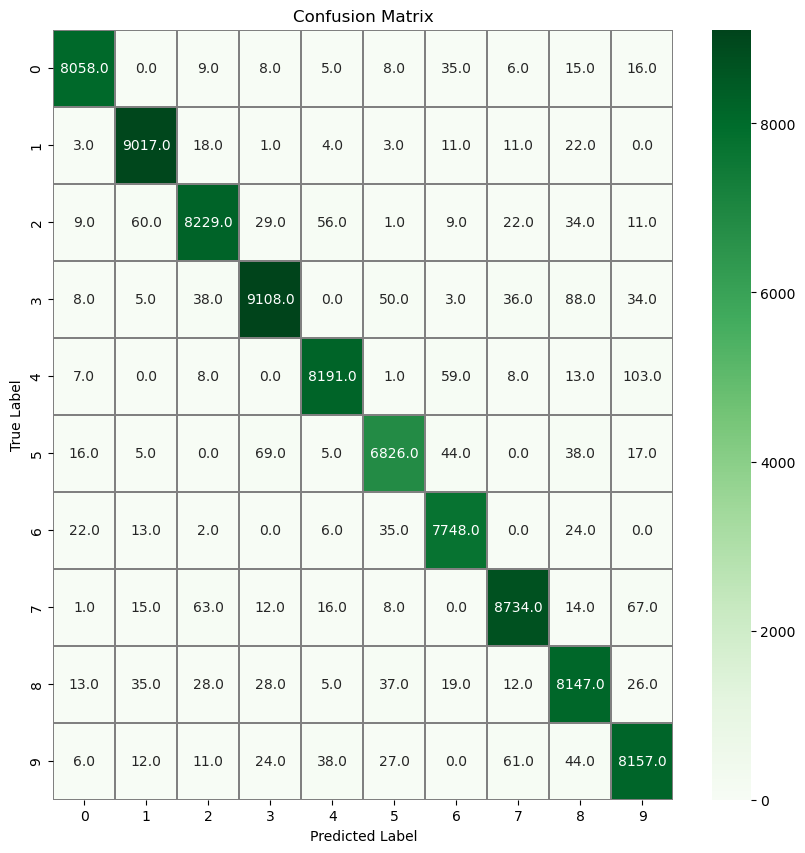

In [18]:
preds = [tensor.item() for tensor in all_preds]
targets = [tensor.item() for tensor in all_targets]
confusion_mtx = confusion_matrix(targets, preds)
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

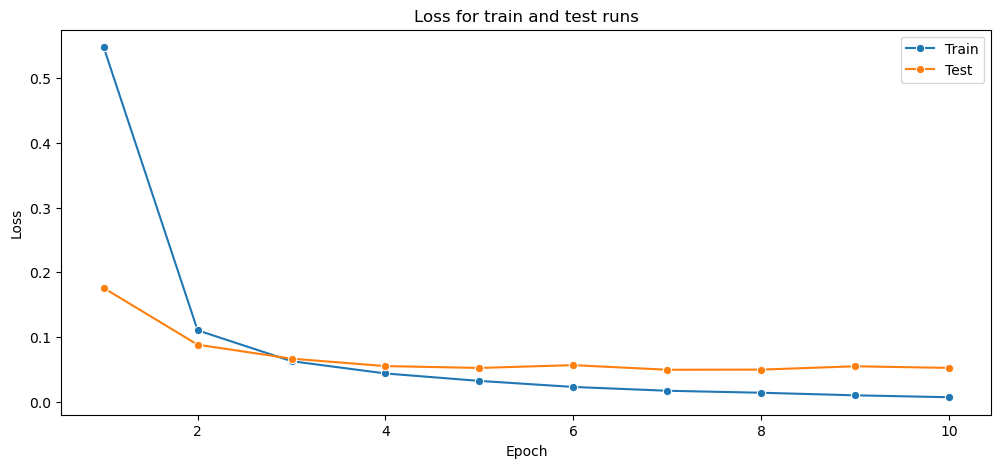

In [19]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Test', marker='o')
plt.title('Loss for train and test runs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

## Faza 2

[GitHub Repo](https://github.com/Coderx7/SimpleNet_Pytorch/blob/master/cifar/models/simplenet.py) for simplenet310k - cel folosit pt MNIST

In procesul de evaluare, in setul de test, de salvat imaginile care au fost prezise incorect de catre model, cu tuple: `idx`, `clasa prezisa`, `clasa adevarata`. 
De salvat imaginile intr-un director separat format de genul: `"im14_0_9"`.

> ! Split-ul in train,val,test este standardizat?



In [20]:
import sys

# Add the directory to the Python path in this notebook 
sys.path.append('/home/iustin/SimpleNet_Pytorch/MNIST')

from models.simplenet import simplenet_cifar_310k

In [21]:
import os 
os.getcwd()

'/home/iustin'

In [22]:
import models
# from torch.utils.tensorboard import SummaryWriter

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [23]:
net = models.__dict__['simplenet_cifar_310k'](num_classes=10)

In [24]:
summary(net, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 1, 1]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─BatchNorm2d (1)                   [1, 64, 28, 28]      [1, 64, 28, 28]      128                  True
│    └─ReLU (2)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Dropout2d (3)                     [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (4)                        [1, 64, 28, 28]      [1, 32, 28, 28]      18,464               True
│    └─BatchNorm2d (5)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (6)   

In [25]:
criterion = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-3, # momentum=state['momentum'],
                                     weight_decay=0.001)

In [26]:
#Break
abcd 

NameError: name 'abcd' is not defined

In [ ]:
def train(net, device, train_loader, criterion, optimizer, train_loss_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.2f}%')
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector)

In [ ]:
def evaluation(net, device, test_loader, criterion, test_loss_collector):
    net.eval() 
    # test_loss = 0
    correct_test = 0
    test_loss = list()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            test_loss.append(loss.item())
            preds = output.argmax(dim=1, keepdim=True)
            correct_test += preds.eq(target.view_as(preds)).sum().item()
            test_loss_collector.append(loss.item())
        print(f'Test loss: {np.round(test_loss, 2)} Test Accuracy: {correct_test}/{len(test_loader.dataset)}'
              f' - {(100. * correct_test / len(test_loader.dataset)):.2f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

In [ ]:
# train_loss_collector = list()
# test_loss_collector = list()
# all_preds = list()
# all_targets = list()
# print('Start training...')
# train(net, device, train_loader, criterion, optimizer, train_loss_collector)
# print('Finish training!')    

In [ ]:
# test_loss_collector = list()
# all_preds = list()
# all_targets = list()
# print('Start training...')
# evaluation(net, device, test_loader, criterion, test_loss_collector)
# print('Finish training!')

train1 difera de train. am adaugat train_accuracy_collector in train 

In [ ]:
def train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        accuracy = list() 
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy.append(correct)
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        train_accuracy_collector.append(np.round(np.mean(accuracy),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.2f}%')
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector)


In [ ]:
train_loss_collector = list()
train_accuracy_collector = list()
test_loss_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector)
print('Finish training!')

Start training...
Epoch: 0/10 	 Loss: 0.1891
Train Accuracy: 95.32%
Test loss: [0.08] Test Accuracy: 8218/8400 - 97.83%
Epoch: 1/10 	 Loss: 0.05086
Train Accuracy: 98.66%
Test loss: [0.04] Test Accuracy: 8313/8400 - 98.96%
Epoch: 2/10 	 Loss: 0.03638
Train Accuracy: 99.01%
Test loss: [0.05] Test Accuracy: 8296/8400 - 98.76%
Epoch: 3/10 	 Loss: 0.02482
Train Accuracy: 99.36%
Test loss: [0.06] Test Accuracy: 8259/8400 - 98.32%
Epoch: 4/10 	 Loss: 0.02108
Train Accuracy: 99.40%
Test loss: [0.1] Test Accuracy: 8161/8400 - 97.15%
Epoch: 5/10 	 Loss: 0.02011
Train Accuracy: 99.48%
Test loss: [0.04] Test Accuracy: 8312/8400 - 98.95%
Epoch: 6/10 	 Loss: 0.01436
Train Accuracy: 99.69%
Test loss: [0.04] Test Accuracy: 8301/8400 - 98.82%
Epoch: 7/10 	 Loss: 0.01354
Train Accuracy: 99.70%
Test loss: [0.05] Test Accuracy: 8277/8400 - 98.54%
Epoch: 8/10 	 Loss: 0.01609
Train Accuracy: 99.60%
Test loss: [0.07] Test Accuracy: 8229/8400 - 97.96%
Epoch: 9/10 	 Loss: 0.01176
Train Accuracy: 99.78%
Test l

In [ ]:
# train_loss_collector
# test_loss_collector

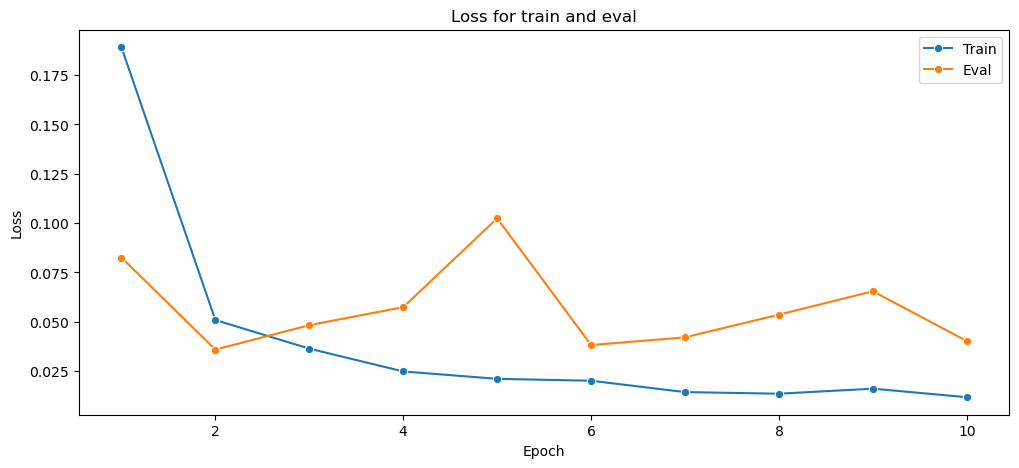

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Eval', marker='o')
plt.title('Loss for train and eval')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

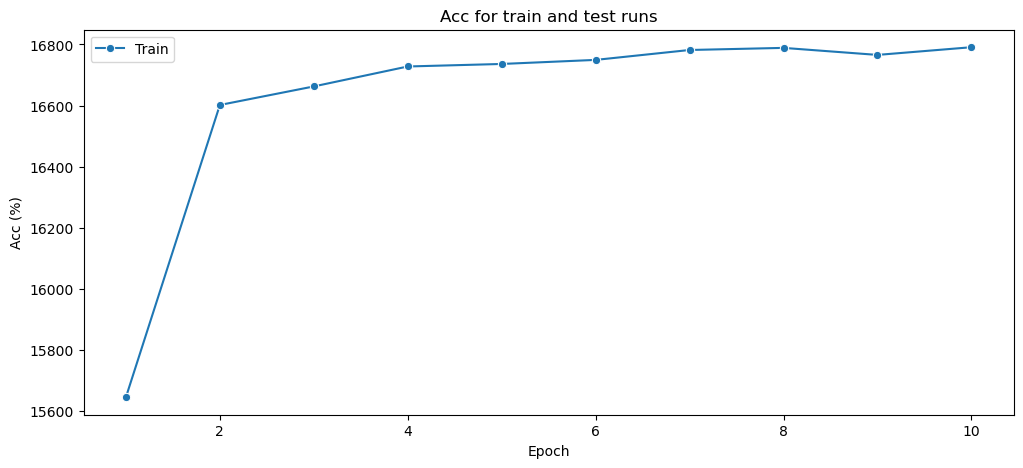

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_accuracy_collector, label='Train', marker='o')
# sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Test', marker='o')
plt.title('Acc for train and test runs')
plt.ylabel('Acc (%)')
plt.xlabel('Epoch')
plt.show();

## De facut

1. De modificat training and eval loop: de adaugat liste de `train_accuracy si test_accuracy` pentru plotare
2. De optimizat hyperparameters pentru a atinge cifrele autorilor, din `main.py`, de adaugat lr scheduler. 
3. De salvat in checkpoint-uri modelul. 
